In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PolynomialFeatures
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.rcParams.update({'font.size': 12})

## Data Cleaning

In [2]:
# read in the df
df = pd.read_csv('Traffic_Crashes_-_Crashes.csv')

# original shape of df
print('original shape', df.shape) 

original shape (431257, 49)


 - Target variable is the 'CRASH_TYPE' column which will be renamed 'SEVERE'
 - The severity of the crash will be determined on whether or not their is an injury / a car being towed
 - This column will be a binary column with 0 representing no injury and 1 representing an injury

In [3]:
# rename column
df.rename(columns = {'CRASH_TYPE': 'SEVERE'}, inplace = True) 
df.SEVERE = df.SEVERE.replace({'NO INJURY / DRIVE AWAY':0,'INJURY AND / OR TOW DUE TO CRASH':1})

In [4]:
df.SEVERE.value_counts()

0    328403
1    102854
Name: SEVERE, dtype: int64

###### Dropped the inconclusive columns and the null values

In [5]:
to_drop = ['CRASH_DATE_EST_I', 'RD_NO', 'LANE_CNT', 'REPORT_TYPE', 'INTERSECTION_RELATED_I', 'NOT_RIGHT_OF_WAY_I',
           'HIT_AND_RUN_I','DATE_POLICE_NOTIFIED', 'STREET_NO','STREET_DIRECTION', 'BEAT_OF_OCCURRENCE',
           'PHOTOS_TAKEN_I','STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I',
           'LATITUDE', 'LONGITUDE','LOCATION','CRASH_RECORD_ID','INJURIES_UNKNOWN','ALIGNMENT','SEC_CONTRIBUTORY_CAUSE',
           'DEVICE_CONDITION', 'STREET_NAME']
df.drop(columns = to_drop, inplace = True)

# New shape of df after dropped columns 
print('new shape', df.shape) 

new shape (431257, 23)


In [6]:
df.drop(df[df.MOST_SEVERE_INJURY.isna()].index, inplace = True)
# New shape of df after dropped columns 
print('new shape', df.shape) 

new shape (430398, 23)


###### Changed the dtype of the 'CRASH_DATE' column

In [7]:
df['CRASH_DATE'] = pd.to_datetime(df.CRASH_DATE)

###### Capped some values from certain continuous columns

In [8]:
# capped at 4
print(df['NUM_UNITS'].value_counts())
df['NUM_UNITS'].values[df['NUM_UNITS'] > 4] = 4
print(df['NUM_UNITS'].value_counts())

2     380492
3      22342
1      22057
4       4105
5        958
6        271
7        100
8         36
9         18
10        10
11         3
12         2
18         1
16         1
15         1
14         1
Name: NUM_UNITS, dtype: int64
2    380492
3     22342
1     22057
4      5507
Name: NUM_UNITS, dtype: int64


In [9]:
# capped at 4
print(df['INJURIES_TOTAL'].value_counts())
df['INJURIES_TOTAL'].values[df['INJURIES_TOTAL'] > 4] = 4
print(df['INJURIES_TOTAL'].value_counts())

0.0     376045
1.0      41234
2.0       8825
3.0       2702
4.0        969
5.0        362
6.0        149
7.0         55
8.0         17
9.0         14
10.0         8
15.0         5
11.0         5
12.0         2
13.0         2
21.0         2
16.0         1
19.0         1
Name: INJURIES_TOTAL, dtype: int64
0.0    376045
1.0     41234
2.0      8825
3.0      2702
4.0      1592
Name: INJURIES_TOTAL, dtype: int64


In [10]:
# capped at 5
print(df['INJURIES_NO_INDICATION'].value_counts())
df['INJURIES_NO_INDICATION'].values[df['INJURIES_NO_INDICATION'] > 5] = 5
print(df['INJURIES_NO_INDICATION'].value_counts())

2.0     203208
1.0     126731
3.0      55765
4.0      21375
5.0       9069
0.0       7518
6.0       3875
7.0       1483
8.0        673
9.0        284
10.0       146
11.0        69
12.0        41
14.0        27
13.0        26
16.0        16
15.0        14
17.0        10
20.0         9
21.0         6
37.0         5
27.0         4
26.0         4
19.0         4
30.0         4
18.0         4
22.0         4
36.0         3
42.0         3
31.0         3
28.0         2
29.0         2
40.0         2
38.0         1
39.0         1
46.0         1
34.0         1
25.0         1
33.0         1
50.0         1
61.0         1
24.0         1
Name: INJURIES_NO_INDICATION, dtype: int64
2.0    203208
1.0    126731
3.0     55765
4.0     21375
5.0     15801
0.0      7518
Name: INJURIES_NO_INDICATION, dtype: int64


###### Merged/Replaced values in certain categorical columns 

In [11]:
# Merged unknown and other into one variable 
df.TRAFFIC_CONTROL_DEVICE = df.TRAFFIC_CONTROL_DEVICE.replace({'UNKNOWN':'UNKNOWN/OTHER','OTHER':'UNKNOWN/OTHER'})
df.ROAD_DEFECT = df.ROAD_DEFECT.replace({'UNKNOWN':'UNKNOWN/OTHER','OTHER':'UNKNOWN/OTHER'})

In [12]:
# Changed to 6 categories
df.WEATHER_CONDITION = df.WEATHER_CONDITION.replace({'UNKNOWN':'UNKNOWN/OTHER','OTHER':'UNKNOWN/OTHER',
                                                    'SLEET/HAIL': 'SNOW', 'FREEZING RAIN/DRIZZLE': 'RAIN',
                                                    'SEVERE CROSS WIND GATE': 'CLOUDY/OVERCAST','BLOWING SNOW': 'SNOW',
                                                    'BLOWING SAND, SOIL, DIRT': 'UNKNOWN/OTHER'})
df.WEATHER_CONDITION = df.WEATHER_CONDITION.replace({'FOG/SMOKE/HAZE': 'FOG', 'CLOUDY/OVERCAST': 'CLOUDY'})
df.WEATHER_CONDITION.value_counts()

CLEAR            340870
RAIN              39465
UNKNOWN/OTHER     19843
SNOW              16385
CLOUDY            13044
FOG                 791
Name: WEATHER_CONDITION, dtype: int64

In [13]:
# merged dusk and dawn because they are very similar lighting conditions 
df.LIGHTING_CONDITION = df.LIGHTING_CONDITION.replace({'DUSK': 'DUSK/DAWN','DAWN': 'DUSK/DAWN' })
df.LIGHTING_CONDITION.value_counts()

DAYLIGHT                  282668
DARKNESS, LIGHTED ROAD     89908
DARKNESS                   21682
DUSK/DAWN                  20678
UNKNOWN                    15462
Name: LIGHTING_CONDITION, dtype: int64

In [14]:
# merged two variables to 'Other'
df.FIRST_CRASH_TYPE = df.FIRST_CRASH_TYPE.replace({'OTHER OBJECT':'OTHER','OTHER NONCOLLISION':'OTHER'})

In [15]:
# merged the different types of intersections into one feature and unknown/other into one feature
df.TRAFFICWAY_TYPE = df.TRAFFICWAY_TYPE.replace({'T-INTERSECTION':'INTERSECTION', 'UNKNOWN INTERSECTION TYPE':'INTERSECTION',
                                                'Y-INTERSECTION':'INTERSECTION','L-INTERSECTION':'INTERSECTION',
                                                 'FIVE POINT, OR MORE': 'INTERSECTION', 'FOUR WAY':'INTERSECTION',
                                                 'ROUNDABOUT': 'INTERSECTION', 'OTHER': 'UNKNOWN/OTHER',
                                                'UNKNOWN':'UNKNOWN/OTHER','NOT REPORTED':'UNKNOWN/OTHER',
                                                'TRAFFIC ROUTE':'UNKNOWN/OTHER'})
df.TRAFFICWAY_TYPE.value_counts()

NOT DIVIDED                        193604
DIVIDED - W/MEDIAN (NOT RAISED)     77616
ONE-WAY                             57107
PARKING LOT                         30746
DIVIDED - W/MEDIAN BARRIER          25929
UNKNOWN/OTHER                       17428
INTERSECTION                        14349
ALLEY                                6929
CENTER TURN LANE                     3806
DRIVEWAY                             1502
RAMP                                 1382
Name: TRAFFICWAY_TYPE, dtype: int64

In [16]:
# Changed to 4 categories
df.ROADWAY_SURFACE_COND = df.ROADWAY_SURFACE_COND.replace({'UNKNOWN':'UNKNOWN/OTHER','OTHER':'UNKNOWN/OTHER',
                                                          'SAND, MUD, DIRT': 'UNKNOWN/OTHER','ICE': 'SNOW OR SLUSH'})
df.ROADWAY_SURFACE_COND = df.ROADWAY_SURFACE_COND.replace({'SNOW OR SLUSH': 'SNOW'})
df.ROADWAY_SURFACE_COND.value_counts()

DRY              322990
WET               59710
UNKNOWN/OTHER     29393
SNOW              18305
Name: ROADWAY_SURFACE_COND, dtype: int64

## Feature Engineering and Data Visualization

###### Creating a date column by creating a day of month column and then merging it with the crash month column

In [17]:
# creating a day column as a string 
df['day'] = pd.DatetimeIndex(df['CRASH_DATE']).day.astype(str)
# merging month and day
df['date'] = df['CRASH_MONTH'].astype(str).str.cat(df['day'].values.astype(str), sep='-')

###### Creating a season column

In [18]:
df['season'] = ' '
df['season'] = np.where((df['CRASH_MONTH'] == 1) | 
                        (df['CRASH_MONTH'] == 2) | 
                        (df['CRASH_MONTH'] == 3), 
                        'Winter', df['season'])
df['season'] = np.where((df['CRASH_MONTH'] == 4) | 
                        (df['CRASH_MONTH'] == 5) | 
                        (df['CRASH_MONTH'] == 6), 
                        'Spring', df['season'])
df['season'] = np.where((df['CRASH_MONTH'] == 7) | 
                        (df['CRASH_MONTH'] == 8) | 
                        (df['CRASH_MONTH'] == 9), 
                        'Summer', df['season'])
df['season'] = np.where((df['CRASH_MONTH'] == 10) | 
                        (df['CRASH_MONTH'] == 11) | 
                        (df['CRASH_MONTH'] == 12), 
                        'Fall', df['season'])

In [19]:
df['day'] = df['day'].astype(int)

## Data Visualization

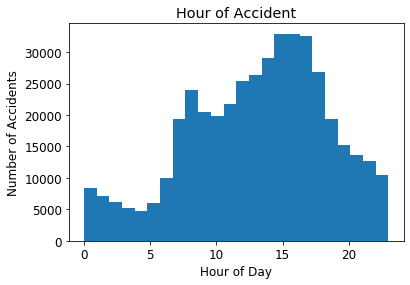

In [20]:
# CRASH_HOUR histogram plot
df.CRASH_HOUR.plot(kind = 'hist', bins = 24)
plt.title('Hour of Accident')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Accidents')
plt.show()

This graph shows that there is an increase an accidents around rush hour time

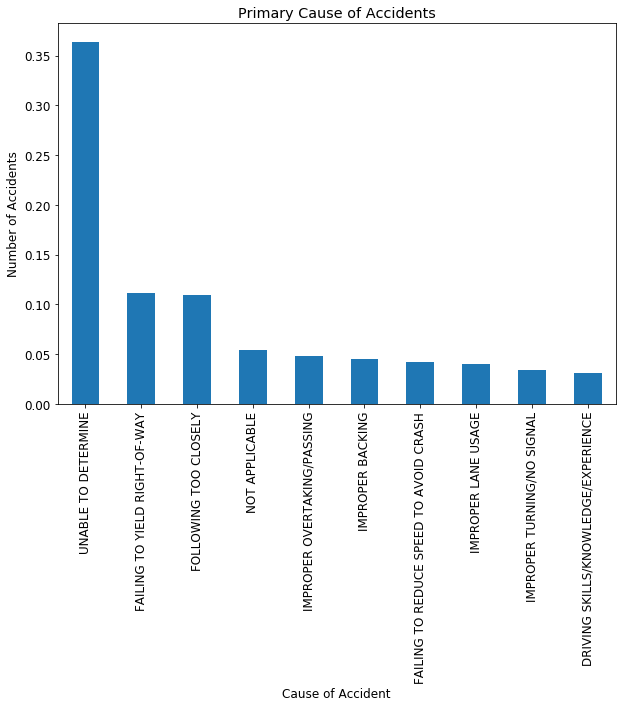

In [21]:
df.PRIM_CONTRIBUTORY_CAUSE.value_counts(normalize = True).head(10).plot(kind = 'bar', figsize = (10,7))
plt.title('Primary Cause of Accidents')
plt.xlabel('Cause of Accident')
plt.ylabel('Number of Accidents')
plt.show()

This graph shows that in most cases we are unable to determine the primary casue of the accident

SEVERE                     0          1
WEATHER_CONDITION                      
CLEAR              79.624366  77.837817
CLOUDY              2.807193   3.745391
FOG                 0.161343   0.255545
RAIN                8.382235  11.686792
SNOW                3.679485   4.214541
UNKNOWN/OTHER       5.345379   2.259915


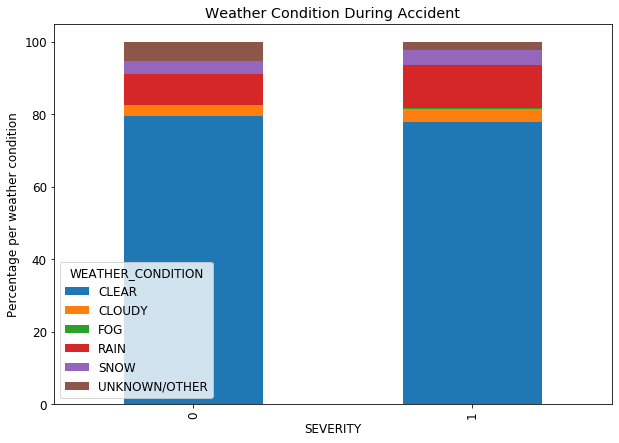

In [22]:
w = df.groupby(['WEATHER_CONDITION', 'SEVERE'])['WEATHER_CONDITION'].count().unstack()
print((w/w.sum())*100)
((w/w.sum())*100).transpose().plot(kind = 'bar', stacked = True, figsize = (10,7))
plt.title('Weather Condition During Accident')
plt.xlabel('SEVERITY')
plt.ylabel('Percentage per weather condition')
plt.show()

SEVERE                        0          1
ROADWAY_SURFACE_COND                      
DRY                   75.345867  74.080721
SNOW                   4.241594   4.289644
UNKNOWN/OTHER          7.841475   3.592260
WET                   12.571064  18.037376


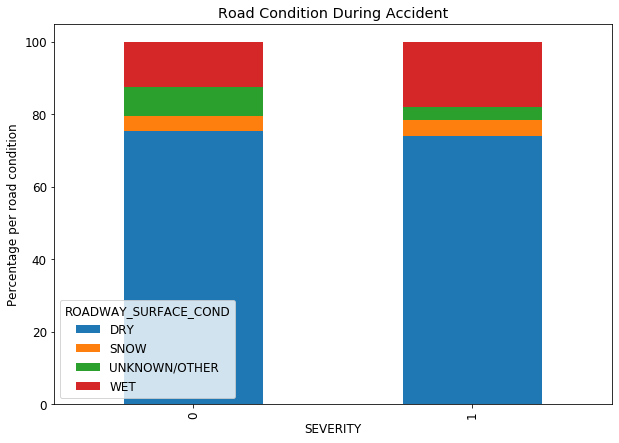

In [23]:
r = df.groupby(['ROADWAY_SURFACE_COND', 'SEVERE'])['ROADWAY_SURFACE_COND'].count().unstack()
print((r/r.sum())*100)
((r/r.sum())*100).transpose().plot(kind = 'bar', stacked = True, figsize = (10,7))
plt.title('Road Condition During Accident')
plt.xlabel('SEVERITY')
plt.ylabel('Percentage per road condition')
plt.show()

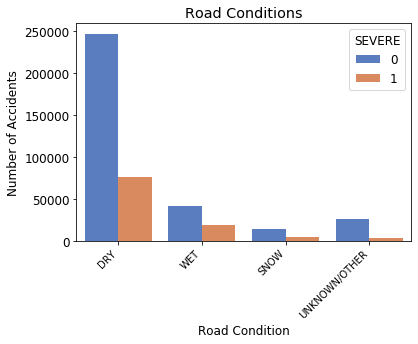

In [24]:
g=sns.countplot(x="ROADWAY_SURFACE_COND", data=df,hue="SEVERE", palette="muted")
plt.title('Road Conditions')
plt.xlabel('Road Condition')
plt.ylabel('Number of Accidents')
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=10);

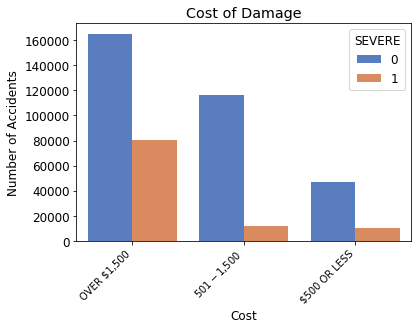

In [25]:
g=sns.countplot(x="DAMAGE", data=df,hue="SEVERE", palette="muted")
plt.title('Cost of Damage')
plt.xlabel('Cost')
plt.ylabel('Number of Accidents')
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=10);

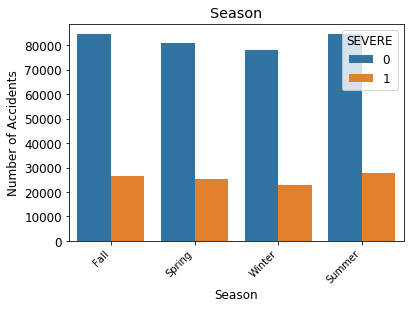

In [26]:
g=sns.countplot(x="season", data=df,hue="SEVERE")
plt.title('Season')
plt.xlabel('Season')
plt.ylabel('Number of Accidents')
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=10);

### Creating Dummies

In [27]:
dummies = ['TRAFFIC_CONTROL_DEVICE', 'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE'
          ,'TRAFFICWAY_TYPE', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'DAMAGE', 'PRIM_CONTRIBUTORY_CAUSE', 'MOST_SEVERE_INJURY'
          ,'season']
df =  pd.get_dummies(df, columns = dummies, drop_first = True )
df.shape

(430398, 123)

##### Feature Interaction

In [28]:
cont = ['POSTED_SPEED_LIMIT', 'NUM_UNITS', 'INJURIES_TOTAL', 'INJURIES_FATAL', 'INJURIES_INCAPACITATING',
        'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
        'CRASH_HOUR', 'CRASH_DAY_OF_WEEK','CRASH_MONTH' ,'day']
poly_df = df[cont]
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_data = poly.fit_transform(poly_df)
poly_columns = poly.get_feature_names(poly_df.columns)
df_poly = pd.DataFrame(poly_data, columns=poly_columns, index = df.index)

df = pd.concat([df,df_poly], axis=1, join='inner')
df = df.loc[:,~df.columns.duplicated()]
df.shape

(430398, 201)

## Feature Selection

In [29]:
target = df['SEVERE']
df_features = df.drop(columns = ['CRASH_DATE','SEVERE', 'date'])

In [30]:
corr_matrix = df_features.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
#upper

In [31]:
corr_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
print(corr_drop)

['ROAD_DEFECT_UNKNOWN/OTHER', 'MOST_SEVERE_INJURY_INCAPACITATING INJURY', 'MOST_SEVERE_INJURY_NO INDICATION OF INJURY', 'MOST_SEVERE_INJURY_NONINCAPACITATING INJURY', 'MOST_SEVERE_INJURY_REPORTED, NOT EVIDENT', 'POSTED_SPEED_LIMIT^2', 'POSTED_SPEED_LIMIT INJURIES_TOTAL', 'POSTED_SPEED_LIMIT INJURIES_FATAL', 'POSTED_SPEED_LIMIT INJURIES_INCAPACITATING', 'POSTED_SPEED_LIMIT INJURIES_NON_INCAPACITATING', 'POSTED_SPEED_LIMIT INJURIES_REPORTED_NOT_EVIDENT', 'POSTED_SPEED_LIMIT INJURIES_NO_INDICATION', 'POSTED_SPEED_LIMIT CRASH_HOUR', 'POSTED_SPEED_LIMIT CRASH_DAY_OF_WEEK', 'POSTED_SPEED_LIMIT CRASH_MONTH', 'POSTED_SPEED_LIMIT day', 'NUM_UNITS^2', 'NUM_UNITS INJURIES_TOTAL', 'NUM_UNITS INJURIES_FATAL', 'NUM_UNITS INJURIES_INCAPACITATING', 'NUM_UNITS INJURIES_NON_INCAPACITATING', 'NUM_UNITS INJURIES_REPORTED_NOT_EVIDENT', 'NUM_UNITS INJURIES_NO_INDICATION', 'NUM_UNITS CRASH_HOUR', 'NUM_UNITS CRASH_DAY_OF_WEEK', 'NUM_UNITS CRASH_MONTH', 'NUM_UNITS day', 'INJURIES_TOTAL^2', 'INJURIES_TOTAL INJU

In [32]:
df_features.drop(columns = corr_drop, inplace = True)

## Hypothesis Tests

In [33]:
w = w.transpose()
print(w)

# Null Hypothesis: Proportion of Severe Accidents is equal in Clear, Wet and Snow Weather Conditions.
# Alternate hypothesis: Proportion of Severe Accidents is not equal in Clear, Wet and Snow Weather Conditions.


data = [[261066, 27483, 12064], [79804, 11982, 4321]]
stat, p, dof, expected = chi2_contingency(data)
# interpret p-value 
alpha = 0.05
print("p value is " + str(p)) 
if p <= alpha: 
    print('Dependent (reject H0)') 
else: 
    print('Independent (H0 holds true)') 

WEATHER_CONDITION   CLEAR  CLOUDY  FOG   RAIN   SNOW  UNKNOWN/OTHER
SEVERE                                                             
0                  261066    9204  529  27483  12064          17526
1                   79804    3840  262  11982   4321           2317
p value is 4.2973326659792144e-212
Dependent (reject H0)


In [34]:
r = r.transpose()
print(r)

# Null Hypothesis: Proportion of Severe Accidents is equal in Dry, Snow and Wet Road Conditions.
# Alternate hypothesis: Proportion of Severe Accidents is not equal Dry, Snow and Wet Road Conditions.


data = [[247038, 13907, 41217], [75952, 4398, 1893]]
stat, p, dof, expected = chi2_contingency(data)
# interpret p-value 
alpha = 0.05
print("p value is " + str(p)) 
if p <= alpha: 
    print('Dependent (reject H0)') 
else: 
    print('Independent (H0 holds true)') 


ROADWAY_SURFACE_COND     DRY   SNOW  UNKNOWN/OTHER    WET
SEVERE                                                   
0                     247038  13907          25710  41217
1                      75952   4398           3683  18493
p value is 0.0
Dependent (reject H0)


### VIF

In [35]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_features.values, i) for i in range(df_features.shape[1])]
vif["features"] = df_features.columns
vif.round(1)

,VIF Factor,features
0,512.0,POSTED_SPEED_LIMIT
1,580.3,NUM_UNITS
2,70.7,INJURIES_TOTAL
3,2.4,INJURIES_FATAL
4,8.8,INJURIES_INCAPACITATING
5,36.9,INJURIES_NON_INCAPACITATING
6,23.4,INJURIES_REPORTED_NOT_EVIDENT
7,90.0,INJURIES_NO_INDICATION
8,103.0,CRASH_HOUR
9,84.8,CRASH_DAY_OF_WEEK


In [36]:
vif_drop =  list(vif[vif['VIF Factor'] > 9]['features'])
print(vif_drop)
print(len(vif_drop))

['POSTED_SPEED_LIMIT', 'NUM_UNITS', 'INJURIES_TOTAL', 'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'day', 'TRAFFIC_CONTROL_DEVICE_NO CONTROLS', 'TRAFFIC_CONTROL_DEVICE_STOP SIGN/FLASHER', 'TRAFFIC_CONTROL_DEVICE_TRAFFIC SIGNAL', 'TRAFFIC_CONTROL_DEVICE_UNKNOWN/OTHER', 'LIGHTING_CONDITION_DAYLIGHT', 'TRAFFICWAY_TYPE_DIVIDED - W/MEDIAN (NOT RAISED)', 'TRAFFICWAY_TYPE_NOT DIVIDED', 'TRAFFICWAY_TYPE_ONE-WAY', 'PRIM_CONTRIBUTORY_CAUSE_DISREGARDING STOP SIGN', 'PRIM_CONTRIBUTORY_CAUSE_DISREGARDING TRAFFIC SIGNALS', 'PRIM_CONTRIBUTORY_CAUSE_DISTRACTION - FROM INSIDE VEHICLE', 'PRIM_CONTRIBUTORY_CAUSE_DRIVING SKILLS/KNOWLEDGE/EXPERIENCE', 'PRIM_CONTRIBUTORY_CAUSE_EQUIPMENT - VEHICLE CONDITION', 'PRIM_CONTRIBUTORY_CAUSE_FAILING TO REDUCE SPEED TO AVOID CRASH', 'PRIM_CONTRIBUTORY_CAUSE_FAILING TO YIELD RIGHT-OF-WAY', 'PRIM_CONTRIBUTORY_CAUSE_FOLLOWING TOO CLOSELY', 'PRIM_CONTRIBUTORY_CAUSE_IMPROPER BAC

In [37]:
df_features.drop(columns = vif_drop, inplace = True)

In [38]:
df_features['target'] = target

In [39]:
df_features.to_pickle("data.pkl")